In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import precision_recall_curve as PRC
from sklearn import preprocessing, impute

train = pd.read_hdf('../data/train_feats_od.h5')
test = pd.read_hdf('../data/test_feats_od.h5')
metatrain = pd.read_csv('../data/training_set_metadata.csv')

In [12]:
train.columns

Index(['hostgal_photoz_err', 'flux_mean_0', 'flux_mean_5', 'flux_min_1',
       'flux_min_2', 'flux_min_5', 'flux_std_0', 'flux_std_1', 'flux_std_2',
       'flux_std_5', 'flux_skew_1', 'flux_skew_2', 'flux_skew_3',
       'flux_skew_4', 'flux_skew_5', 'flux_kurt_1', 'flux_kurt_2',
       'flux_kurt_3', 'flux_kurt_4', 'flux_kurt_5',
       'cross_band_flux_mean_contrib_0', 'cross_band_flux_mean_contrib_1',
       'cross_band_flux_mean_contrib_2', 'cross_band_flux_mean_contrib_3',
       'cross_band_flux_mean_contrib_4', 'cross_band_flux_mean_contrib_5',
       'cross_band_flux_max_contrib_0', 'cross_band_flux_max_contrib_1',
       'cross_band_flux_max_contrib_2', 'cross_band_flux_max_contrib_3',
       'cross_band_flux_max_contrib_4', 'cross_band_flux_max_contrib_5',
       'det_amplitude', 'det_avg_1_block_duration', 'cross_detected_contrib_1',
       'cross_detected_contrib_2', 'cross_detected_contrib_3',
       'cross_detected_contrib_5', 'linreg_b1_0_110_band2',
       'linreg_b1_

Training fold num. 0
Training fold num. 1
Training fold num. 2
Training fold num. 3
Training fold num. 4
Training fold num. 5
Training fold num. 6
Training fold num. 7
Training fold num. 8
Training fold num. 9
Precision recall results :


/Users/miguelrita/anaconda2/envs/titanic/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1)

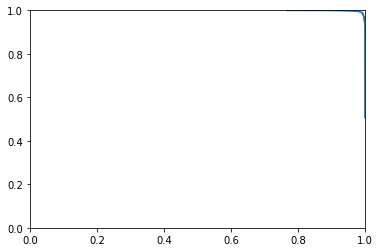

In [75]:
# Define base sets
X_train = train.values
X_test_all = test.values

# Draw random sample from test
sample_size = 80000
random_ixs = np.arange(0,X_test_all.shape[0])
np.random.shuffle(random_ixs)
random_ixs = random_ixs[:sample_size]
X_test = X_test_all[random_ixs]

# Assign labels to both - 1 belongs to train, 0 to test and concat
y_train = np.ones((X_train.shape[0],1))
y_test = np.zeros((X_test.shape[0],1))

# Scale
X_train = preprocessing.StandardScaler().fit_transform(X_train)
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# Impute
X_train = impute.SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train)
X_test = impute.SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_test)

X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# Train simple classifier on several folds and average predictions
y_oof = np.zeros(shape=y.shape[0])
clf = RFC(max_depth=2, n_estimators=100)
folds = SKF(n_splits=10, shuffle=True, random_state=1)

for fold_num, (train_, eval_) in enumerate(folds.split(y, y)):
    print(f'Training fold num. {fold_num:d}')
    X_fold_train, X_fold_eval = X[train_], X[eval_]
    y_fold_train, y_fold_eval = y[train_], y[eval_]
    
    clf.fit(X_fold_train, y_fold_train[:,0])
    y_oof[eval_] = clf.predict_proba(X_fold_eval)[:,1]

prr = PRC(y_true=y, probas_pred=y_oof, pos_label=1)
print(f'Precision recall results :')
ax = sns.lineplot(prr[0], prr[1])
ax.set_xlim(0,1)
ax.set_ylim(0,1)

/Users/miguelrita/anaconda2/envs/titanic/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


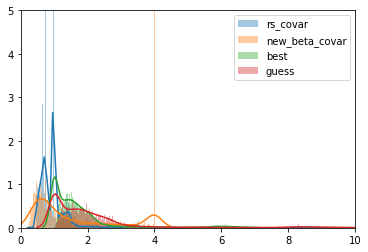

In [104]:
# Plot resulting beta dist vs. simple rs covariate beta

new_beta = y_oof[:X_train.shape[0]]
beta_rs = np.load('../data/rs_plus2_covar_beta.npy')
bins_ = np.linspace(0,10,1000)
sns.distplot(beta_rs, kde=True, label='rs_covar', bins=bins_)
new_beta
new_beta = 1/new_beta-1
new_beta /= np.median(new_beta)
new_beta = np.clip(new_beta, 0, 4)
ax = sns.distplot(new_beta, kde=True, label='new_beta_covar', bins=bins_)
simple_rs_beta = 1 + 2 * metatrain['hostgal_photoz'].values
sns.distplot(simple_rs_beta, kde=True, label='best', bins=bins_)
guess_rs_beta = 1 + 3 * metatrain['hostgal_photoz'].values
sns.distplot(guess_rs_beta, kde=True, label='guess', bins=bins_)
ax.set_ylim(0,5)
ax.set_xlim(0,10)
plt.legend()

In [92]:
pd.Series(new_beta).describe()

count   7848.00
mean       1.63
std        1.31
min        0.17
25%        0.60
50%        1.00
75%        2.58
max        4.00
dtype: float64

In [95]:
# Save experimental new beta
np.save('../data/exp_covar_beta_v1.npy', new_beta)

In [100]:
train.columns

Index(['hostgal_photoz_err', 'flux_mean_0', 'flux_mean_5', 'flux_min_1',
       'flux_min_2', 'flux_min_5', 'flux_std_0', 'flux_std_1', 'flux_std_2',
       'flux_std_5', 'flux_skew_1', 'flux_skew_2', 'flux_skew_3',
       'flux_skew_4', 'flux_skew_5', 'flux_kurt_1', 'flux_kurt_2',
       'flux_kurt_3', 'flux_kurt_4', 'flux_kurt_5',
       'cross_band_flux_mean_contrib_0', 'cross_band_flux_mean_contrib_1',
       'cross_band_flux_mean_contrib_2', 'cross_band_flux_mean_contrib_3',
       'cross_band_flux_mean_contrib_4', 'cross_band_flux_mean_contrib_5',
       'cross_band_flux_max_contrib_0', 'cross_band_flux_max_contrib_1',
       'cross_band_flux_max_contrib_2', 'cross_band_flux_max_contrib_3',
       'cross_band_flux_max_contrib_4', 'cross_band_flux_max_contrib_5',
       'det_amplitude', 'det_avg_1_block_duration', 'cross_detected_contrib_1',
       'cross_detected_contrib_2', 'cross_detected_contrib_3',
       'cross_detected_contrib_5', 'linreg_b1_0_110_band2',
       'linreg_b1_